In [4]:
import numpy as np
import math
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sympy import *
from scipy.special import gamma
from tqdm import tqdm
import scipy
from scipy.optimize import minimize
 

In [2]:
"""
--------------------------------------------------
Package for 3 parameter Mittag Leffler obtained from:
https://github.com/khinsen/mittag-leffler
------------------------------------------------
"""

#LT Inversion for ML

def LTInversion(t,lamda,alpha,beta,gama,log_epsilon):
    # Evaluation of the relevant poles
    theta = np.angle(lamda)
    kmin = np.ceil(-alpha/2. - theta/2./np.pi)
    kmax = np.floor(alpha/2. - theta/2./np.pi)
    k_vett = np.arange(kmin, kmax+1)
    s_star = np.abs(lamda)**(1./alpha) * np.exp(1j*(theta+2*k_vett*np.pi)/alpha)

    # Evaluation of phi(s_star) for each pole
    phi_s_star = (np.real(s_star)+np.abs(s_star))/2

    # Sorting of the poles according to the value of phi(s_star)
    index_s_star = np.argsort(phi_s_star)
    phi_s_star = phi_s_star.take(index_s_star)
    s_star = s_star.take(index_s_star)

    # Deleting possible poles with phi_s_star=0
    index_save = phi_s_star > 1.0e-15
    s_star = s_star.repeat(index_save)
    phi_s_star = phi_s_star.repeat(index_save)

    # Inserting the origin in the set of the singularities
    s_star = np.hstack([[0], s_star])
    phi_s_star = np.hstack([[0], phi_s_star])
    J1 = len(s_star)
    J = J1 - 1

    # Strength of the singularities
    p = gama*np.ones((J1,), float)
    p[0] = max(0,-2*(alpha*gama-beta+1))
    q = gama*np.ones((J1,), float)
    q[-1] = np.inf
    phi_s_star = np.hstack([phi_s_star, [np.inf]])

    # Looking for the admissible regions with respect to round-off errors
    admissible_regions = \
       np.nonzero(np.bitwise_and(
           (phi_s_star[:-1] < (log_epsilon - np.log(np.finfo(np.float64).eps))/t),
           (phi_s_star[:-1] < phi_s_star[1:])))[0]
    # Initializing vectors for optimal parameters
    JJ1 = admissible_regions[-1]
    mu_vett = np.ones((JJ1+1,), float)*np.inf
    N_vett = np.ones((JJ1+1,), float)*np.inf
    h_vett = np.ones((JJ1+1,), float)*np.inf

    # Evaluation of parameters for inversion of LT in each admissible region
    find_region = False
    while not find_region:
        for j1 in admissible_regions:
            if j1 < J1-1:
                muj, hj, Nj = OptimalParam_RB(t, phi_s_star[j1], phi_s_star[j1+1], p[j1], q[j1], log_epsilon)
            else:
                muj, hj, Nj = OptimalParam_RU(t, phi_s_star[j1], p[j1], log_epsilon)
            mu_vett[j1] = muj
            h_vett[j1] = hj
            N_vett[j1] = Nj
        if N_vett.min() > 200:
            log_epsilon = log_epsilon + np.log(10)
        else:
            find_region = True

    # Selection of the admissible region for integration which
    # involves the minimum number of nodes
    iN = np.argmin(N_vett)
    N = N_vett[iN]
    mu = mu_vett[iN]
    h = h_vett[iN]

    # Evaluation of the inverse Laplace transform
    k = np.arange(-N, N+1)
    u = h*k
    z = mu*(1j*u+1.)**2
    zd = -2.*mu*u + 2j*mu
    zexp = np.exp(z*t)
    F = z**(alpha*gama-beta)/(z**alpha - lamda)**gama*zd
    S = zexp*F ;
    Integral = h*np.sum(S)/2./np.pi/1j

    # Evaluation of residues
    ss_star = s_star[iN+1:]
    Residues = np.sum(1./alpha*(ss_star)**(1-beta)*np.exp(t*ss_star))

    # Evaluation of the ML function
    E = Integral + Residues
    if np.imag(lamda) == 0.:
        E = np.real(E)
    return E

# =========================================================================
# Finding optimal parameters in a right-bounded region
# =========================================================================
def OptimalParam_RB(t, phi_s_star_j, phi_s_star_j1, pj, qj, log_epsilon):
    # Definition of some constants
    log_eps = -36.043653389117154 # log(eps)
    fac = 1.01
    conservative_error_analysis = False

    # Maximum value of fbar as the ration between tolerance and round-off unit
    f_max = np.exp(log_epsilon - log_eps)

    # Evaluation of the starting values for sq_phi_star_j and sq_phi_star_j1
    sq_phi_star_j = np.sqrt(phi_s_star_j)
    threshold = 2.*np.sqrt((log_epsilon - log_eps)/t)
    sq_phi_star_j1 = min(np.sqrt(phi_s_star_j1), threshold - sq_phi_star_j)

    # Zero or negative values of pj and qj
    if pj < 1.0e-14 and qj < 1.0e-14:
        sq_phibar_star_j = sq_phi_star_j
        sq_phibar_star_j1 = sq_phi_star_j1
        adm_region = 1

    # Zero or negative values of just pj
    if pj < 1.0e-14 and qj >= 1.0e-14:
        sq_phibar_star_j = sq_phi_star_j
        if sq_phi_star_j > 0:
            f_min = fac*(sq_phi_star_j/(sq_phi_star_j1-sq_phi_star_j))**qj
        else:
            f_min = fac
        if f_min < f_max:
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fq = f_bar**(-1/qj)
            sq_phibar_star_j1 = (2*sq_phi_star_j1-fq*sq_phi_star_j)/(2+fq)
            adm_region = True
        else:
            adm_region = False

    # Zero or negative values of just qj
    if pj >= 1.0e-14 and qj < 1.0e-14:
        sq_phibar_star_j1 = sq_phi_star_j1
        f_min = fac*(sq_phi_star_j1/(sq_phi_star_j1-sq_phi_star_j))**pj
        if f_min < f_max:
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fp = f_bar**(-1./pj)
            sq_phibar_star_j = (2.*sq_phi_star_j+fp*sq_phi_star_j1)/(2-fp)
            adm_region = True
        else:
            adm_region = False

    # Positive values of both pj and qj
    if pj >= 1.0e-14 and qj >= 1.0e-14:
        f_min = fac*(sq_phi_star_j+sq_phi_star_j1) / \
                (sq_phi_star_j1-sq_phi_star_j)**max(pj, qj)
        if f_min < f_max:
            f_min = max(f_min,1.5)
            f_bar = f_min + f_min/f_max*(f_max-f_min)
            fp = f_bar**(-1/pj)
            fq = f_bar**(-1/qj)
            if ~conservative_error_analysis:
                w = -phi_s_star_j1*t/log_epsilon
            else:
                w = -2.*phi_s_star_j1*t/(log_epsilon-phi_s_star_j1*t)
            den = 2+w - (1+w)*fp + fq
            sq_phibar_star_j = ((2+w+fq)*sq_phi_star_j + fp*sq_phi_star_j1)/den
            sq_phibar_star_j1 = (-(1.+w)*fq*sq_phi_star_j + (2.+w-(1.+w)*fp)*sq_phi_star_j1)/den
            adm_region = True
        else:
            adm_region = False

    if adm_region:
        log_epsilon = log_epsilon  - np.log(f_bar)
        if not conservative_error_analysis:
            w = -sq_phibar_star_j1**2*t/log_epsilon
        else:
            w = -2.*sq_phibar_star_j1**2*t/(log_epsilon-sq_phibar_star_j1**2*t)
        muj = (((1.+w)*sq_phibar_star_j + sq_phibar_star_j1)/(2.+w))**2
        hj = -2.*np.pi/log_epsilon*(sq_phibar_star_j1-sq_phibar_star_j) \
             / ((1.+w)*sq_phibar_star_j + sq_phibar_star_j1)
        Nj = np.ceil(np.sqrt(1-log_epsilon/t/muj)/hj)
    else:
        muj = 0.
        hj = 0.
        Nj = np.inf

    return muj, hj, Nj

In [3]:
#Optimal Param for ML
def OptimalParam_RU(t, phi_s_star_j, pj, log_epsilon):
    # Evaluation of the starting values for sq_phi_star_j
    sq_phi_s_star_j = np.sqrt(phi_s_star_j)
    if phi_s_star_j > 0:
        phibar_star_j = phi_s_star_j*1.01
    else:
        phibar_star_j = 0.01
    sq_phibar_star_j = np.sqrt(phibar_star_j)

    # Definition of some constants
    f_min = 1
    f_max = 10
    f_tar = 5

    # Iterative process to look for fbar in [f_min,f_max]
    while True:
        phi_t = phibar_star_j*t
        log_eps_phi_t = log_epsilon/phi_t
        Nj = np.ceil(phi_t/np.pi*(1. - 3*log_eps_phi_t/2 + np.sqrt(1-2*log_eps_phi_t)))
        A = np.pi*Nj/phi_t
        sq_muj = sq_phibar_star_j*np.abs(4-A)/np.abs(7-np.sqrt(1+12*A))
        fbar = ((sq_phibar_star_j-sq_phi_s_star_j)/sq_muj)**(-pj)
        if (pj < 1.0e-14) or (f_min < fbar and fbar < f_max):
            break
        sq_phibar_star_j = f_tar**(-1./pj)*sq_muj + sq_phi_s_star_j
        phibar_star_j = sq_phibar_star_j**2
    muj = sq_muj**2
    hj = (-3*A - 2 + 2*np.sqrt(1+12*A))/(4-A)/Nj
    
    # Adjusting integration parameters to keep round-off errors under control
    log_eps = np.log(np.finfo(np.float64).eps)
    threshold = (log_epsilon - log_eps)/t
    if muj > threshold:
        if abs(pj) < 1.0e-14:
            Q = 0
        else:
            Q = f_tar**(-1/pj)*np.sqrt(muj)
        phibar_star_j = (Q + np.sqrt(phi_s_star_j))**2
        if phibar_star_j < threshold:
            w = np.sqrt(log_eps/(log_eps-log_epsilon))
            u = np.sqrt(-phibar_star_j*t/log_eps)
            muj = threshold
            Nj = np.ceil(w*log_epsilon/2/np.pi/(u*w-1))
            hj = np.sqrt(log_eps/(log_eps - log_epsilon))/Nj
        else:
            Nj = np.inf
            hj = 0

    return muj, hj, Nj

## 3 Parameter Mittag-Leffler

\begin{align}
E^\gamma_{\alpha,\beta} (z) = \frac{1}{\Gamma(\gamma)} \sum^\infty_{k=0} \frac{\Gamma(\gamma + k) z^k}{k! \Gamma (\alpha k + \beta)}
\end{align}

In [4]:
#Mittag Leffler 

def ml(z, alpha, beta=1., gama=1.):
    '''
3 Parameter Mittag Leffler Function
   ---------------------
The Mittag Leffler with 3 parameters:
z : float
z value is the convergence.
Parameters
alpha : float
beta : float
gama : float
---------------------
    Can be changed into 1 or 2 parameters by setting beta and gamma = 1
    2 parameters, gama = 1
    1 parameter , beta = 1, gama = 1
    '''
    eps = np.finfo(np.float64).eps
    if np.real(alpha) <= 0 or np.real(gama) <= 0 or np.imag(alpha) != 0. \
       or np.imag(beta) != 0. or np.imag(gama) != 0.:
        raise ValueError('ALPHA and GAMA must be real and positive. BETA must be real.')
    if np.abs(gama-1.) > eps:
        if alpha > 1.:
            raise ValueError('GAMMA != 1 requires 0 < ALPHA < 1')
        if (np.abs(np.angle(np.repeat(z, np.abs(z) > eps))) <= alpha*np.pi).any():
            raise ValueError('|Arg(z)| <= alpha*pi')

    return np.vectorize(ml_, [np.float64])(z, alpha, beta, gama)

def ml_(z, alpha, beta, gama):
    # Target precision 
    log_epsilon = np.log(1.e-15)
    # Inversion of the LT
    if np.abs(z) < 1.e-15:
        return 1/gamma(beta)
    else:
        return LTInversion(1, z, alpha, beta, gama, log_epsilon)

## One parameter Mittag-Leffler 

\begin{align}
E_{\gamma,\delta} (z) = \sum^\infty_{n=0} \frac{z^n}{\Gamma (n\alpha + 1)}
\end{align}

## Two Parameter Mittag-Leffler
\begin{align}
E_{\gamma,\delta} (z) = \sum^\infty_{n=0} \frac{z^n}{\Gamma (n\alpha + \beta)}
\end{align}


## Relationship between ML Functions

$$E^1_{\alpha,\beta} = E_{\alpha,\beta} (z) $$
$$E_{\alpha,1}(z) = E_{\alpha}(z)$$ 

For any $\alpha , \beta, \gamma$, with $\alpha$ and $\gamma$ being real and $\beta$ being real and positive.
\begin{align}
    E^\gamma_{\alpha,\beta} = \frac{1}{\Gamma (\gamma)} D_z^{\gamma-1} \left[ z^{\gamma-1} E_{\alpha,\beta}(z) \right]
\end{align}

## $F_\beta (t)$ for Fractional Hawkes
For Fractional Hawkes, we will start with the 3 parameter ML and set:

$\alpha = \beta , \beta = \beta , \gamma = 1$

\begin{align}
E^\gamma_{\alpha,\beta} (z) = \frac{1}{\Gamma(\gamma)} \sum^\infty_{k=0} \frac{\Gamma(\gamma + k) z^k}{k! \Gamma (\alpha k + \beta)} \\
f_\beta (t) = \frac{dE_\beta (-t^\beta)}{dt} = t^{\beta-1} E_{\beta,\beta} (-t^\beta)
\end{align}

## General form of $f_\beta(t)$
\begin{align}
f_\beta(t) &= t^{\beta-1} E_{\beta,\beta}^1 (-t^\beta) \\
&= t^{\beta-1} \sum^\infty_{n=0} \frac{{-t^\beta}^n}{\Gamma(n\beta + \beta)} \\
&= \frac{t^{\beta-1}}{\Gamma(\beta)} - \frac{t^{2\beta-1}}{\Gamma(2 \beta)}
\end{align}

We have that $(0 < \beta < 1$) and $E_{\beta,\beta} (- t^\beta) = \sum_{n=0}^\infty \frac{(-1)^n t^{\beta n}}{\Gamma(n \beta + \beta)}$.

The first two terms in the expansion are ($n=0$ and $n=1$) therefore:
$\frac{1}{\Gamma(\beta)} - \frac{t^\beta}{\Gamma(2 \beta)}$

if you multiply by $t^{\beta - 1}$ you get $\frac{t^{\beta-1}}{\Gamma(\beta)} - \frac{t^2\beta -1}{\Gamma(2 \beta)}$
if you send $t$ to $0$, the first term diverges, whereas the second one goes to $0$ (and all the other terms in the series expansion vanish).



In [5]:
#f_beta function
def f_betaml(beta, t):
    ''' ml(z, alpha, beta, gama)'''
    return t**(beta-1) * ml(-t**beta, beta, beta, 1)

In [6]:
"""
F_beta function
   --------
resml : array to keep results
t must be an int starting > 0, as z cannot be -t**0
f_betaml(z, beta, t, gama)
Parameters:
z = float (-t**beta)
beta = float(decay)
-----------
"""
resml = []

for t in range (1,11):
    s = f_betaml( 0.7, t)
    resml.append(s)
print (resml)

[0.21039334638902382, 0.0886936584628374, 0.04862434271845458, 0.0305522631800429, 0.02092996378708683, 0.015227600531481068, 0.011581366219158614, 0.009112861981623713, 0.007365538176356337, 0.006083694408277395]


Text(0, 0.5, 'Cumulative Integral Value')

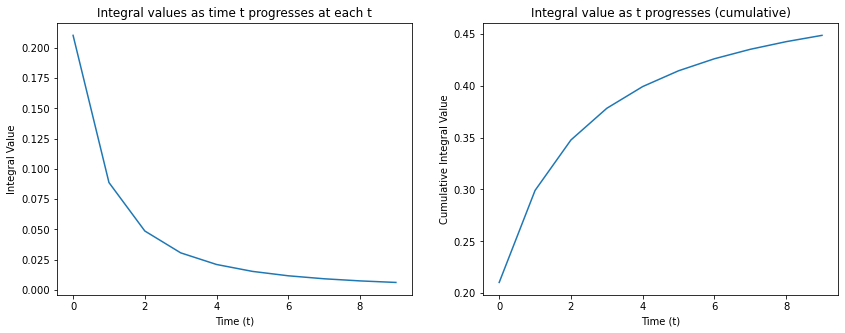

In [7]:
#Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(t), resml)
axes[0].set_title('Integral values as time t progresses at each t')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('Integral Value')

axes[1].plot(range(t), np.cumsum(resml))
axes[1].set_title('Integral value as t progresses (cumulative)')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Cumulative Integral Value')

## Conditional Intensity Function
\begin{align}
\lambda_t &= \lambda_0 + \alpha \sum f_\beta(t-t_i) \\
&= \mu +\alpha \sum f_\beta(t-u)
\end{align}

In [8]:
#The Lambda Max for Fractional Hawkes

def cih_elapsed(mat, jt, a, beta, alpha):
    '''
Conditional Intensity Fuction for Hawkes.
    
    Parameters
    ----------
    mat: int/float (maximum time)
    jt: Jump time counter
    a: int (constant reversion level, >0, lambda at t = 0)
    beta: float (decay, >0)
    alpha: int(excitation)
    z: float(z value)
    gama: float(Gamma)

    Lambda_t = lambda + alpha* sum (f_beta(t-ti))
    Returns Lambda of Hawkes
    ----------
    '''
    lambda_hawkes = a
    jt = np.array(jt)
    
    if len(jt)>0:
        jt = jt[jt<mat]
        lambda_hawkes = lambda_hawkes + alpha*np.sum(f_betaml(beta, mat-jt))
        
    return(lambda_hawkes)

## Simulating Fractional Hawkes 
--------------------------
1. Set initial time, $t=0$ and final time as mat:float
2. Compute lambda_max for some small value of $e$ (t+some small value, in this case $(1e-12$)
3. Generate a positive exponentially distributed random variable E with the meaning of a
waiting time, with rate 1/lambda_max.
4. Set t = t+R
5. Generate random uniform $U2 [0, 1]$
6.If U2 < conditional intensity/ lambda_max, set $ti+1 = t$ and update time to $t = t+R$, otherwise, just set
$t = t+R$.
7. Return to step 2 until $t$ exceeds mat.
8. Return the set of event times (or epochs) $ti$
-------------------------

In [9]:
#Exponential Kernel Hawkes

def simFracHawkes_elapsed(mat , a, beta, alpha):
    '''
Ogata's Thinning Method, p(x) = Conditional intensity func/lambda max
    '''
    t = 0
    jt = np.array([])
    
    while t < mat:
        lambda_max = cih_elapsed(t+1e-12, jt, a, beta, alpha)
        R = np.random.exponential(1/lambda_max)
        U2 = np.random.uniform(0,1)
        
        if U2 > cih_elapsed(t+R, jt, a, beta, alpha) / lambda_max:
            t = t+R ## reject and move that t is t+R so that lambda_max is then calculated on this
            
        else:
            t = t+R
            jt = np.append(jt, t)
            
    return jt[jt<mat]
                    

In [10]:
def plotIntensity(mat, a, beta, alpha):
    '''
    Plots the Hawkes Intensity Function (for constant excitations).
    
    Parameters
    ----------
    mat: int/float (maximum time)
    a: int (constant reversion level / lambda at t = 0)
    beta: float (decay)
    alpha: int(excitation) not the alpha for ML as we have set it to be a 1 parameter (beta)
    z: float(z value)
    gama: float(Gamma)

    ----------

    '''
   
    rjt = simFracHawkes_elapsed(mat, a, beta, alpha)
    timeline = np.linspace(0,mat,1000)
    fig, ax = plt.subplots(figsize=(10,8))
    
## lambda values for all t, including jump times
    lambda_values = []
    for j in timeline:
        lambda_values=np.append(lambda_values, cih_elapsed(j, rjt, a, beta, alpha)) 

                                                           
## lambda values at jump times [left limits]
    lambda_values2 = []
    for j in rjt:
        lambda_values2 = np.append(lambda_values2,cih_elapsed(j, rjt, a,beta, alpha))
                                                              
## lambda values at jump times [left limits] (Supposedly j+0.001 but it looks better with j+0.005)
    lambda_values3 = []
    for j in rjt:
        lambda_values3 = np.append(lambda_values3,cih_elapsed(j+0.005, rjt, a, beta, alpha))
                                                              
## plot the intensity as a function of time
    ax.plot(timeline,lambda_values,color='blue',linewidth=0.5)
## plot the jump times
    ax.plot(rjt, [0.45]*len(rjt), '|', color='red')
                                                              
## plot left limits
    ax.plot(rjt, lambda_values2, 'bo',fillstyle='none',markersize=3,color='black')
                                                              
## plot right limits
    ax.plot(rjt, lambda_values3, 'bo',fillstyle='full',markersize=3,color='black')
    ax.set_title('Fractional Hawkes intensity process with constant excitations')
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Intensity $\lambda_t$')
    fig.tight_layout()
    plt.show()

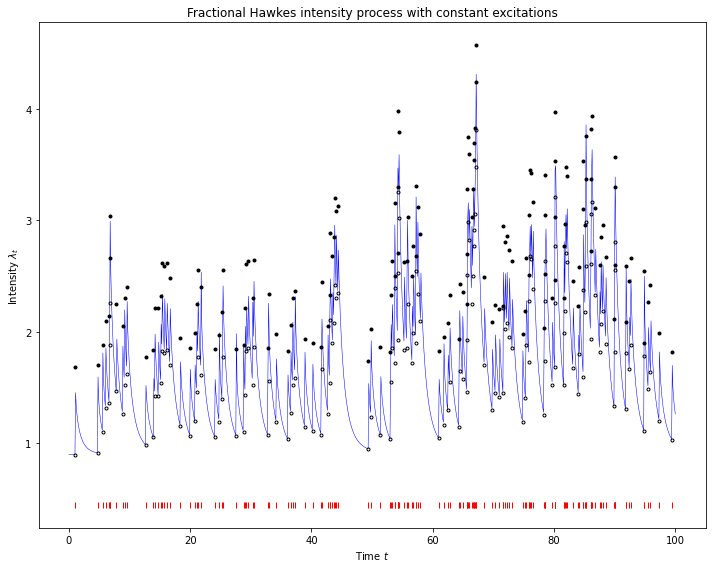

In [11]:
# plotIntensity(mat,a,beta,alpha)
'''
Parameters for Plotting Intensity Function
-----------------------------------------
mat: float (Max time/T)
a: float (constant reversion level) 
beta: float(decay), conditions: beta < 1
alpha: float(excitation), conditions: alpha < 1
z: -t**beta
-------------------------------------
It will plot the kernel intensity process with constant excitations
'''

plotIntensity(100, 0.9, 0.9, 0.5)

## Theoretical Mean of Fractional Hawkes

\begin{align}
E[\lambda_t] = 
\end{align}

In [12]:
def theoryMeanIntensity(param, mat):
    '''
-------------------------------------------------------
In Process of derivation!
------------------------------------------------------

'''
    a = param[0]
    beta = param[1]
    alpha = param[2]

    lambda_hawkes =   a + np.sum(f_betaml(beta, t) )
    return lambda_hawkes 

In [13]:
def empMeanHawkes(param, mat, num_path):
    '''
Calculate Empirical Mean of Fractional Hawkes
-------------------------------------------------------
E[Nt] = Mean of Simulated Fractional Hawkes

simFracHawkes_elapsed(mat, a, beta, alpha, z)
------------------------------------------------------
'''
    a = param[0]
    beta = param[1]
    alpha = param[2]
    
    path_numjt = np.zeros((num_path,1))
    
    for i in tqdm(range(0, num_path)):
        
        tmp = simFracHawkes_elapsed(mat, a, beta, alpha)
        
        if len(tmp)==0:
            path_numjt[i, 0]=0
        
        else:
            path_numjt[i, 0]=len(tmp)
    return np.mean(path_numjt)

In [14]:
'''
Ground Truth Check
------------------------------------------------------------------------
Theoractical Mean of Fractional Hawkes must be close to Empirical Mean
Parameters:
a : float (lambda at t=0)
beta : float (decay)
alpha : float (excitation)
z : float (-t**beta)
------------------------------------------------------------------------
'''
print("Theory and Empircal must match")
print("Theory still in derivation")
#print("Theory Mean Hawkes :", theoryMeanIntensity([1, 0.7, 0.9], 100))

#print("Empirical Mean Hawkes :", empMeanHawkes([1, 0.7, 0.9], 10, 100))

Theory and Empircal must match
Theory still in derivation


In [15]:
### Maximum likelihood estimation for exponential Hawkes
### This is the delicate function within the log likelihood for Hawkes
def inner_ll(z, jt, mu, alpha, beta):
    '''mu = lambda at  t=0'''
    mu=0
    jt = np.array(jt)
    
    inner = mu + alpha * np.sum( f_betaml(beta, jt[z]-jt[0:z]) )
    return(inner)



## Log-Likelihood of Fractional Hawkes:


\begin{align}
\ell = \sum^{N_T}_{i=1} ln (\lambda (t_i)) - \Lambda(T) 
\end{align}



In [26]:
def loglikHawkes(theta, *args):
    '''Set the parameters to recover from minimize using theta[i]'''
    mat = args[0][0]
    jt = args[0][1]
    mu = theta[0]
    beta = theta[1]
    alpha = theta[2]
    
    #Start from 0
    loglik = 0
    for z in range (1, len(jt)):
        loglik +=  np.log( inner_ll(z, jt, mu, alpha, beta) ) - cih_elapsed(z+1e-12, jt, a, beta, alpha)
    
    return -loglik

#Classical Hawkes
# first_term = - mu*mat
# second_term = - 1/delta * alpha * sum(1-np.exp(-delta*(mat-jt)))
#for z in range(1,len(jt))]
# third_term = + np.sum([np.log( inner_ll(z,jt,mu,alpha,delta) ) 

In [27]:
#Test Log-likeihood Function
#Disabled Unless needed
''' For this to work add [0] into mat and jt. mat = args[0][0], jt = args[0][1]'''
#loglikHawkes([100,0.9,0.9] , [100, simFracHawkes_elapsed(100 , 1, 0.9, 0.9)])


-189.3918138212455

In [18]:
#Run MLE for Fractional Hawkes
#Parameters
''' simFracHawkes_elapsed(mat, a, beta, alpha) '''
mat = 100
mu = 1
a = 1
beta = 0.9
alpha = 0.9
jt = simFracHawkes_elapsed(100, 1, 0.9, 0.9)

print ("Simulated Jumps of Fractional Hawkes", jt)
print ("Number of Jumps", len(jt))

Simulated Jumps of Fractional Hawkes [ 0.54312687  0.5794212   1.05401638  1.18641546  1.47598559  1.74058641
  1.75020744  1.97584637  2.69702045  2.91521316  3.0690687   3.13124952
  3.25908118  3.29093744  3.3533551   3.40332824  3.46734406  3.54159662
  3.55904249  3.9021655   4.02153055  4.05727376  4.11464806  4.17655166
  4.1833186   4.40722492  4.63488948  4.83128084  4.85273109  4.92095658
  4.93744831  5.01778966  5.08645106  5.09262262  5.116793    5.25866607
  5.40997545  5.46814333  5.52289102  5.59174962  5.65627224  6.20590951
  6.60100461  6.64511833  6.80541673  6.87985493  7.37942617  7.56554071
  7.81383578  7.8915584   7.94924948  8.19922534  8.19947125  8.40157367
  8.45534748  8.57992644  8.62994677  8.7752196   8.79023832  9.30911984
  9.81293348 10.00576284 10.38678246 10.96628426 11.51846863 12.85983364
 12.93137262 13.49336571 13.8037619  14.0476168  14.06352866 14.0978901
 14.21515633 14.87200134 14.87204451 15.1511914  15.16215461 15.24876223
 15.7947878  16

In [19]:
#Minimization to return parameters 
res = minimize(loglikHawkes, np.array([1, 0.9, 0.9]),args = (mat,jt), method = 'Nelder-Mead')

In [20]:
print(res.x)
print(mu, beta, alpha)


[0.95478038 0.9743944  1.00879727]
1 0.9 0.9


## EM Algorithm 

In [6]:
#def exp_log_likelihood(hist_t, t, theta):
 #   lambda0, alpha, beta = theta
  #  t = hist_t
   # N_t = len(t)
#
 #   A = np.empty(N_t, dtype=np.float64)
  #  A[0] = 0
   # for i in range(1, N_t):
    #    A[i] = np.exp(-beta*(t[i] - t[i-1])) * (1 + A[i-1])
#
 #   ell = -lambda0*t
  #  for i, t_i in enumerate(hist_t):
   #     ell += np.log(lambda0 + alpha * A[i]) - (alpha/beta) * (1 - np.exp(-beta*(t-t_i)))
    #return ell

In [7]:
def em_responsibilities(t, theta):
    '''The function for Complete Data Log-Likelihood'''
    lambda0, alpha, beta = theta
    N = len(t)
    resp = np.empty((N,N), dtype=np.float64)

    for i in prange(0,N):
        if i == 0:
            resp[i, 0] = 1.0
            for j in range(1, N):
                resp[i, j] = 0.0
        else:
            resp[i, 0] = lambda0
            rowSum = lambda0

            for j in range(1, i+1):
                resp[i, j] = alpha*np.exp(-beta*(t[i] - t[j-1]))
                rowSum += resp[i, j]

            for j in range(0, i+1):
                resp[i, j] /= rowSum

            for j in range(i+1, N):
                resp[i, j] = 0.0
    return resp


def exp_em(t, T, theta_start=np.array([1.0, 2.0, 3.0]), iters=100, verbosity=None, calcLikelihoods=False):
    """
    Run an EM fit on the 't' arrival times up until final time 'T'.
    hp.fit(array<float>, float) -> array<float>
    """
    theta = theta_start.copy()

    llIterations = np.zeros(iters)
    iters = tqdm(range(iters)) if verbosity else range(iters)

    for i in iters:
        theta, ll = exp_em_iter(t, T, theta, calcLikelihoods)
        llIterations[i] = ll

        if verbosity and i % verbosity == 0:
            print(theta[0], theta[1], theta[2])

    if calcLikelihoods:
        return theta, llIterations
    else:
        return theta



def exp_em_iter(t, T, theta, calcLikelihoods):
    lambda0, alpha, beta = theta
    N = len(t)

    # E step (This is the Complete Data Log-Likelihood)
    resp = em_responsibilities(t, theta)

    # M step: Update lambda0
    lambda0 = np.sum(resp[:,0])/T

    # M step: Update alpha
    numer = np.sum(resp[:,1:])
    denom = np.sum(1 - np.exp(-beta*(T - t)))
    alpha = beta*numer/denom

    # M step: Update beta
    numer = np.sum(1 - np.exp(-beta*(T - t)))/beta - np.sum((T - t)*np.exp(-beta*(T - t)))

    denom = 0
    for j in prange(1, N):
        denom += np.sum((t[j] - t[:j])*resp[j,1:j+1])

    beta = alpha*numer/denom

    if calcLikelihoods:
        ll = exp_log_likelihood(t, T, theta)
    else:
        ll = 0.0

    theta[0] = lambda0
    theta[1] = alpha
    theta[2] = beta

    return theta, ll


# Metropolitan-Hastings

In [ ]:
# GENERATE DATA for AR(1)

T = 10000
x = np.zeros(T)

sigma2 = 1
alpha = 0.4
beta = 0.6
tau2 = sigma2/(1-beta)
eta = alpha/(1-beta)

for t in range (1,T):  
    x[t] = alpha + beta*x[t-1] + np.random.normal(0, sigma2)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.hist(x,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Generated Data")
mu_obs=x.mean()
mu_obs

# SET LOG-LIKELIHOOD
def evaluateLogLikelihood(params):
    sigma2 = params[0]
    alpha = params[1]
    beta = params[2]
    return np.sum((1/np.sqrt(2*np.pi*sigma2)) * np.log(-(1/(2*sigma2))*(x[t] - alpha - beta*x[t-1])**2))


# MAIN STUFF

# initial guess for our parameters
guess = [1.0, 1.0, 1.0]
# Prepare storing MCMC chain as array of arrays
A = [guess]
# define stepsize of MCMC
stepsizes = [0.005, 0.005, 0.005]  # array of stepsizes
accepted  = 0.0

# Metropolis-Hastings with 10,000 iterations
for n in range(10000):
    old_alpha  = A[len(A)-1]  # old parameters value as array (the guess)
    old_loglik = evaluateLogLikelihood(old_alpha)
    
    # Suggest new candidate from Gaussian proposal distribution(Uniform) #Should be using probably a normal distribution or Jeffrey Prior
    new_alpha = np.zeros([len(old_alpha)])
    for i in range(len(old_alpha)):
    
        # Use stepsize provided for every dimension
        new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
    new_loglik = evaluateLogLikelihood(new_alpha)
    
    # Accept new candidate
    if (new_loglik > old_loglik):
        A.append(new_alpha)
        accepted = accepted + 1.0  # monitor acceptance
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A.append(new_alpha)
            accepted = accepted + 1.0  # monitor acceptance
        else:
            A.append(old_alpha)

print("Acceptance rate = " + str(accepted/10000.0))

# RESULTS
# Discard first half of MCMC chain and thin out the rest.(BURN IN)
sigma2_estimate = []
alpha_estimate = []
beta_estimate = []

for n in range(5000,10000):
    if (n % 10 == 0):
        sigma2_estimate.append(A[n][0])
        alpha_estimate.append(A[n][1])
        beta_estimate.append(A[n][2])


# Print Monte-Carlo estimate of parameters
print("sigma2 mean:  "+str(np.mean(sigma2_estimate)))
print("sigma2 std: "+str(np.std(sigma2_estimate)))

print("alpha mean:  "+str(np.mean(alpha_estimate)))
print("alpha std: "+str(np.std(alpha_estimate)))

print("beta mean:  "+str(np.mean(beta_estimate)))
print("beta std: "+str(np.std(beta_estimate)))

plt.hist(sigma2_estimate, 20, lw=3)
plt.hist(alpha_estimate, 20, lw=3)
plt.hist(beta_estimate, 20, lw=3)

# For some reason it is still kind of wonky, I suspect that using a uniform prior probably has made it deviate from the ground truth.
